In [88]:
import pickle
import pandas as pd
import json 
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import cv2

SHOULD_REBUILD = False
IMG_PATH_DIR = '../'
PREPROCESSED_FORM_IMG_PATH = 'preprocessed_form_imgs/'
FORM_IMG_SIZE = (3542, 2479)

# Loading dataset

In [23]:
def get_preprocessed_form_img_path_from_id(form_id):
    return PREPROCESSED_FORM_IMG_PATH + form_id + '.png'

df = pd.read_pickle('../../pickle/df.pickle')
bad_df = df[df['total_words'] != df['correct_words']]
df = df[df['total_words'] == df['correct_words']]
df.head()

,index,word_id,gray_level,x,y,w,h,tag,transcription,word_img_path,...,form_id,writer_id,text_id,number_of_sentences,word_seg,total_lines,correct_lines,total_words,correct_words,form_img_path_y
36,52,a01-000x-00-00,182,375,767,35,67,AT,A,../data/words/a01/a01-000x/a01-000x-00-00.png,...,a01-000x,001,a01,2,all,6,6,52,52,../data/formsA-D/a01-000x.png
37,53,a01-000x-00-01,182,506,763,143,66,NN,MOVE,../data/words/a01/a01-000x/a01-000x-00-01.png,...,a01-000x,001,a01,2,all,6,6,52,52,../data/formsA-D/a01-000x.png
38,54,a01-000x-00-02,182,730,760,44,70,TO,to,../data/words/a01/a01-000x/a01-000x-00-02.png,...,a01-000x,001,a01,2,all,6,6,52,52,../data/formsA-D/a01-000x.png
39,55,a01-000x-00-03,182,832,764,89,114,VB,stop,../data/words/a01/a01-000x/a01-000x-00-03.png,...,a01-000x,001,a01,2,all,6,6,52,52,../data/formsA-D/a01-000x.png
40,56,a01-000x-00-04,182,1001,760,84,71,NPT,Mr.,../data/words/a01/a01-000x/a01-000x-00-04.png,...,a01-000x,001,a01,2,all,6,6,52,52,../data/formsA-D/a01-000x.png


In [87]:
import numpy as np

print("Longueur de la db: {}".format(len(df)))
print("Max x: {}".format(np.max(df.x.values)))
print("Max y: {}".format(np.max(df.y.values)))

Longueur de la db: 41981
Max x: 2458
Max y: 2773


# Visualizing

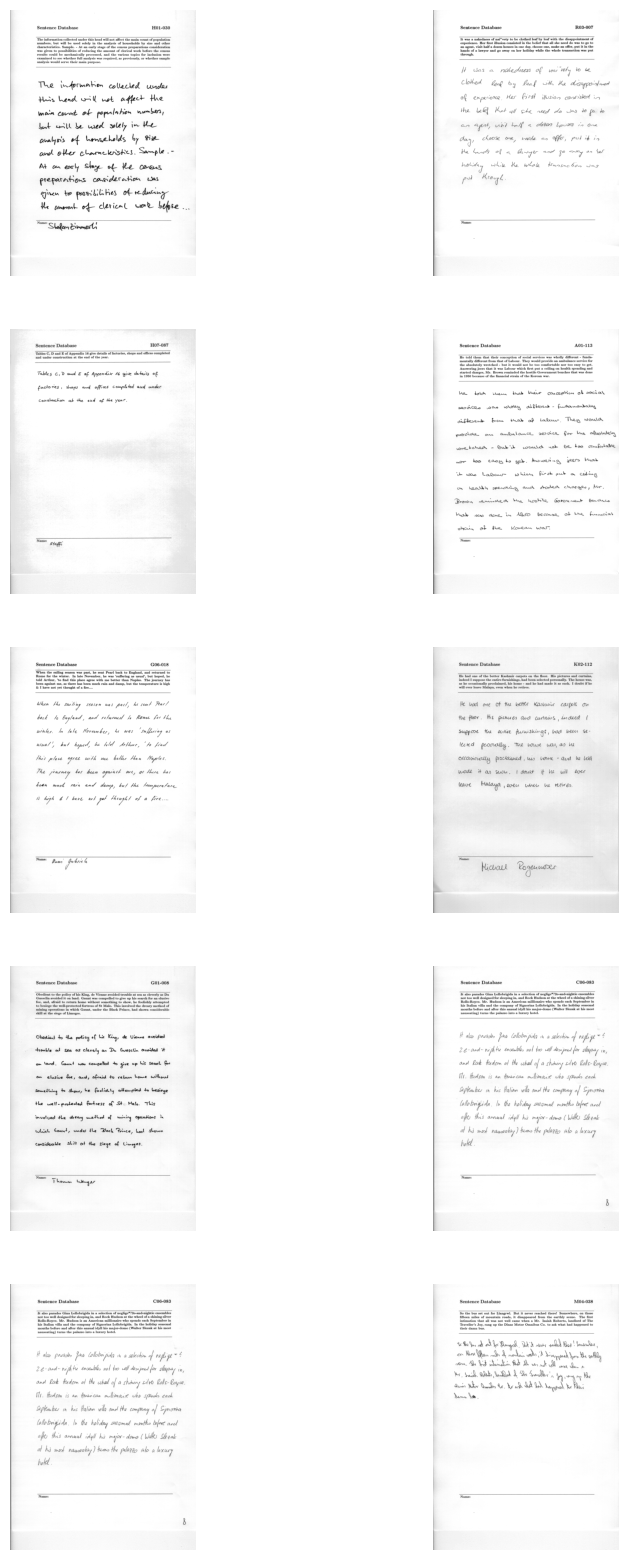

In [25]:
fig = plt.figure(figsize=(10,20))
nb_rows = 5
nb_cols = 2
img_paths = random.sample(list(df.form_img_path_y), nb_rows * nb_cols)
for i in range(nb_rows * nb_cols):
    fig.add_subplot(nb_rows, nb_cols, i + 1)
    plt.imshow(plt.imread('../' + img_paths[i]), cmap='gray')
    plt.axis('off')
plt.show()

# Preprocessing

In [26]:
@tf.function
def load_image(filepath):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=0)
    return im

@tf.function
def preprocess(filepath, img_size=(32, 128), data_augmentation=False, scale=0.8, is_threshold=False, with_edge_detection=True):
    img = load_image(filepath)/255 # To work with values between 0 and 1
    img_original_size = tf.shape(img)

    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = tf.ones([img_size[0], img_size[1], 1])
        res = tf.expand_dims(img, -1)
        return res

    # increase dataset size by applying random stretches to the images
    if data_augmentation:
        stretch = scale*(tf.random.uniform([1], 0, 1)[0] - 0.3) # -0.5 .. +0.5
        w_stretched = tf.maximum(int(float(img_original_size[0]) * (1 + stretch)), 1) # random width, but at least 1
        img = tf.image.resize(img, (w_stretched, img_original_size[1])) # stretch horizontally by factor 0.5 .. 1.5


    # Rescale
    # create target image and copy sample image into it
    (wt, ht) = img_size
    w, h = float(tf.shape(img)[0]), float(tf.shape(img)[1])
    fx = w / wt
    fy = h / ht
    f = tf.maximum(fx, fy)
    newSize = (tf.maximum(tf.minimum(wt, int(w / f)), 1), tf.maximum(tf.minimum(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = tf.image.resize(img, newSize)

    # Add padding
    dx = wt - newSize[0]
    dy = ht - newSize[1]
    if data_augmentation:
        dx1=0
        dy1=0
        if dx != 0:
            dx1 = tf.random.uniform([1], 0, dx, tf.int32)[0]
        if dy != 0:
            dy1 = tf.random.uniform([1], 0, dy, tf.int32)[0]
        img = tf.pad(img[..., 0], [[dx1, dx-dx1], [dy1, dy-dy1]], constant_values=1)
    else:
        img = tf.pad(img[..., 0], [[0, dx], [0, dy]], constant_values=1)

    if is_threshold:
        img = 1-(1-img)*tf.cast(img < 0.8, tf.float32)

    img = tf.expand_dims(img, -1)
    return img

def generate_preprocessed_imgs_from_df(df, img_size = (32, 128), folder_name = 'preprocessed_imgs', offset=0):
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if index < offset :
            continue
        path = IMG_PATH_DIR + row.word_img_path
        img_array = preprocess(path, img_size=img_size,  data_augmentation=True, is_threshold=True).numpy()
        cv2.imwrite(folder_name + '/' + row.word_id + '.png', cv2.cvtColor(img_array * 255, cv2.COLOR_RGB2BGR))

def generate_preprocessed_form_imgs_from_df(df, img_size = FORM_IMG_SIZE, folder_name = PREPROCESSED_FORM_IMG_PATH, offset=0, limit=1500):
    i = 0
    form_df = df.drop_duplicates(subset=['form_id'])
    for index, row in tqdm(form_df.iterrows(), total=len(form_df)):
        if index < offset :
            continue
        path = IMG_PATH_DIR + row.form_img_path_y
        img_array = preprocess(path, img_size=img_size,  data_augmentation=True, is_threshold=True).numpy()
        cv2.imwrite(folder_name + '/' + row.form_id + '.png', cv2.cvtColor(img_array * 255, cv2.COLOR_RGB2BGR))
        i += 1
        if limit <= i:
            break

In [27]:
# generate_preprocessed_form_imgs_from_df(df, img_size=FORM_IMG_SIZE, offset=0, limit=1500)

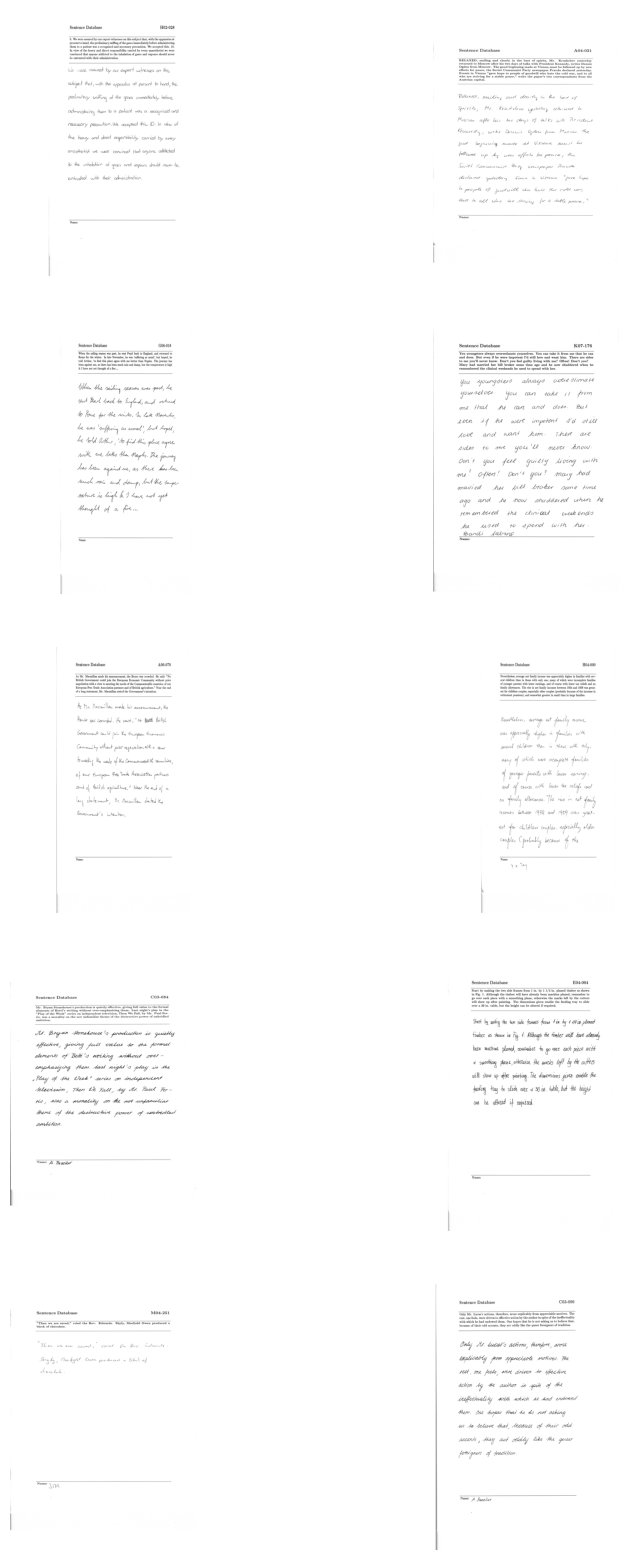

In [28]:
fig = plt.figure(figsize=(10,20))
nb_rows = 5
nb_cols = 2
form_img_ids = random.sample(list(set(df.form_id)), nb_rows * nb_cols)
for i in range(nb_rows * nb_cols):
    fig.add_subplot(nb_rows, nb_cols, i + 1)
    plt.imshow(plt.imread(get_preprocessed_form_img_path_from_id(form_img_ids[i])), cmap='gray')
    plt.axis('off')
plt.show()

# Find full coordinates

In [102]:
from doctr.models import ocr_predictor
from doctr.io import DocumentFile

def scale_doctr_coords(img_detection_result, size = (1,1)):
    ''' 
    Return the scaled coordinates as an array of 4-point arrays 
    '''
    height = size[0]
    width = size[1]
    trans_coords = [[
        [arr[0] * width, arr[1] * height], #xmin #ymin
        [arr[2] * width, arr[1] * height], #xmax #ymin
        [arr[2] * width, arr[3] * height], #xmax #ymax
        [arr[0] * width, arr[3] * height], #xmin #ymax
    ] for arr in img_detection_result]
    return trans_coords


def get_doctr_coords_for_img(model, img_path, is_scaling=False):
    form_img_arr = plt.imread(img_path)
    doc = DocumentFile.from_images(img_path)
    det_res = model.det_predictor(doc)
    shape = (1, 1)
    if is_scaling:
        shape = form_img_arr.shape
    return scale_doctr_coords(det_res[0], size=shape)

def create_full_coords_doctr_file(df, save=False):
    if not save:
        with open("doctr_coords.json") as f:
            return json.load(f)

    doctr_coords_json = {}

    model = ocr_predictor(
        det_arch = 'db_resnet50',    
        reco_arch = 'crnn_vgg16_bn', 
        pretrained = True
    )

    for form_id in tqdm(list(set(df.form_id))):
        form_img_path = get_preprocessed_form_img_path_from_id(form_id)
        doctr_coords_json[form_img_path] = get_doctr_coords_for_img(model, form_img_path)
        
    with open("doctr_coords.json", "w") as outfile:
        json.dump(doctr_coords_json, outfile, indent=4, sort_keys=False)
    return doctr_coords_json

In [30]:
doctr_coords_json = create_full_coords_doctr_file(df, save=SHOULD_REBUILD)

### Test

In [114]:
test_form_id = df.iloc[0].form_id
form_img_path = get_preprocessed_form_img_path_from_id(test_form_id)
abs_coords = doctr_coords_json[get_preprocessed_form_img_path_from_id(test_form_id)]
abs_coords

[[[338.92578125, 2819.072265625],
  [481.7587890625, 2819.072265625],
  [481.7587890625, 2860.580078125],
  [338.92578125, 2860.580078125]],
 [[1200.765625, 1622.263671875],
  [1476.748046875, 1622.263671875],
  [1476.748046875, 1802.130859375],
  [1200.765625, 1802.130859375]],
 [[382.501953125, 1639.55859375],
  [484.1796875, 1639.55859375],
  [484.1796875, 1736.41015625],
  [382.501953125, 1736.41015625]],
 [[861.83984375, 1625.72265625],
  [1130.5595703125, 1625.72265625],
  [1130.5595703125, 1736.41015625],
  [861.83984375, 1736.41015625]],
 [[663.326171875, 1622.263671875],
  [760.162109375, 1622.263671875],
  [760.162109375, 1781.376953125],
  [663.326171875, 1781.376953125]],
 [[513.23046875, 1622.263671875],
  [597.9619140625, 1622.263671875],
  [597.9619140625, 1736.41015625],
  [513.23046875, 1736.41015625]],
 [[1803.5693359375, 1445.85546875],
  [2062.60546875, 1445.85546875],
  [2062.60546875, 1618.8046875],
  [1803.5693359375, 1618.8046875]],
 [[1433.171875, 1459.69140625

(0.0, 3542.0)
(2479.0, 0.0)


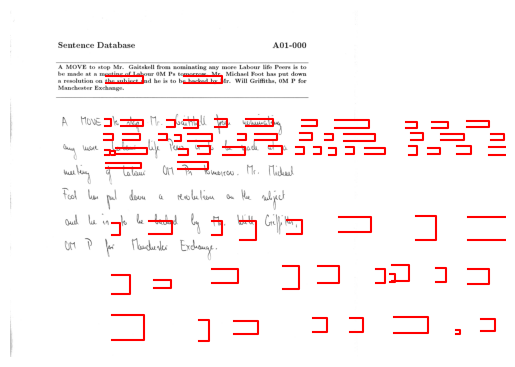

In [125]:
fig, ax = plt.subplots()

plt.axis('off')
ax.imshow(plt.imread(form_img_path), cmap='gray')
ax.set_xlim(0, FORM_IMG_SIZE[1])
ax.set_ylim(FORM_IMG_SIZE[0], 0)
print(ax.get_xlim())
print(ax.get_ylim())
for polygon_data in abs_coords:
    x = np.array(polygon_data)[:,0] + np.array(polygon_data[0][0])
    y = np.array(polygon_data)[:,1] + np.array(polygon_data[0][1]) 
    ax.plot(x, y, color='red')
plt.show()

In [ ]:
for polygon_data in abs_coords:
    x = np.array(polygon_data)[:,0] + np.array(polygon_data[0][0])
    y = np.array(polygon_data)[:,1] + np.array(polygon_data[0][1]) 

# Train/Test Split

In [31]:
import hashlib

IMG_DIM_ATTR_LABEL = 'img_dimensions'
IMG_HASH_ATTR_LABEL = 'img_hash'
POLYGON_ATTR_LABEL = 'polygons'
IS_TRAIN_ATTR_LABEL = 'is_train'


def get_img_hash(img_arr):
    return hashlib.sha256(img_arr).hexdigest()

def split_in_train_val_img_dicts(df, doctr_coords_json, save=SHOULD_REBUILD):
    if not save:
        with open("text_detection_train/labels.json") as f:
            train_json = json.load(f)
            
        print(len(train_json), "images will be used for training")

        with open("text_detection_val/labels.json") as f:
            val_json = json.load(f)
            
        print(len(val_json), "images will be used for validation")
        return train_json, val_json
    train_img_dict = {}
    val_img_dict = {}
    i = 0
    nb_words = len(df)
    nb_forms = len(list(set(df.form_id)))
    form_ids = set()

    for index, row in tqdm(df.iterrows(), total=len(df)):
        i += 1
        x = row.x
        y = row.y
        width = row.w
        height = row.h
        form_id = row.form_id
        form_ids.add(form_id)
        form_img_path = get_preprocessed_form_img_path_from_id(row.form_id)
        form_img_arr = plt.imread(form_img_path)

        is_train = (len(form_ids) < int(nb_forms * 0.8))           

        box_coordinates = [
            [x, y],
            [x + width, y],
            [x + width, y + height],
            [x, y + height]
        ]

        form_img_filename = row.form_id + '.png'
        form_img_filename = form_img_filename.split('/')[-1]
        
        if is_train:
            future_img_path = 'text_detection_train/'
            if not form_img_filename in train_img_dict:
                doctr_coords = doctr_coords_json[form_img_path]
                train_img_dict[form_img_filename] = {
                    IMG_DIM_ATTR_LABEL: form_img_arr.shape,
                    IMG_HASH_ATTR_LABEL: get_img_hash(form_img_arr),
                    POLYGON_ATTR_LABEL: doctr_coords,
                }
            train_img_dict[form_img_filename][POLYGON_ATTR_LABEL].append(box_coordinates)
        else: 
            future_img_path = 'text_detection_val/'
            if not form_img_filename in val_img_dict:
                doctr_coords = doctr_coords_json[form_img_path]
                val_img_dict[form_img_filename] = {
                    IMG_DIM_ATTR_LABEL: form_img_arr.shape,
                    IMG_HASH_ATTR_LABEL: get_img_hash(form_img_arr),
                    POLYGON_ATTR_LABEL: doctr_coords,
                }
            val_img_dict[form_img_filename][POLYGON_ATTR_LABEL].append(box_coordinates)
        last_form_id = form_id

    with open("text_detection_train/labels.json", "w") as outfile:
        json.dump(train_img_dict, outfile, indent=4, sort_keys=False)
    with open("text_detection_val/labels.json", "w") as outfile:
        json.dump(val_img_dict, outfile, indent=4, sort_keys=False)

    return train_img_dict, val_img_dict

In [32]:
train_json, val_json = split_in_train_val_img_dicts(df, doctr_coords_json, save=SHOULD_REBUILD)

465 images will be used for training
118 images will be used for validation


# Checking coordinates

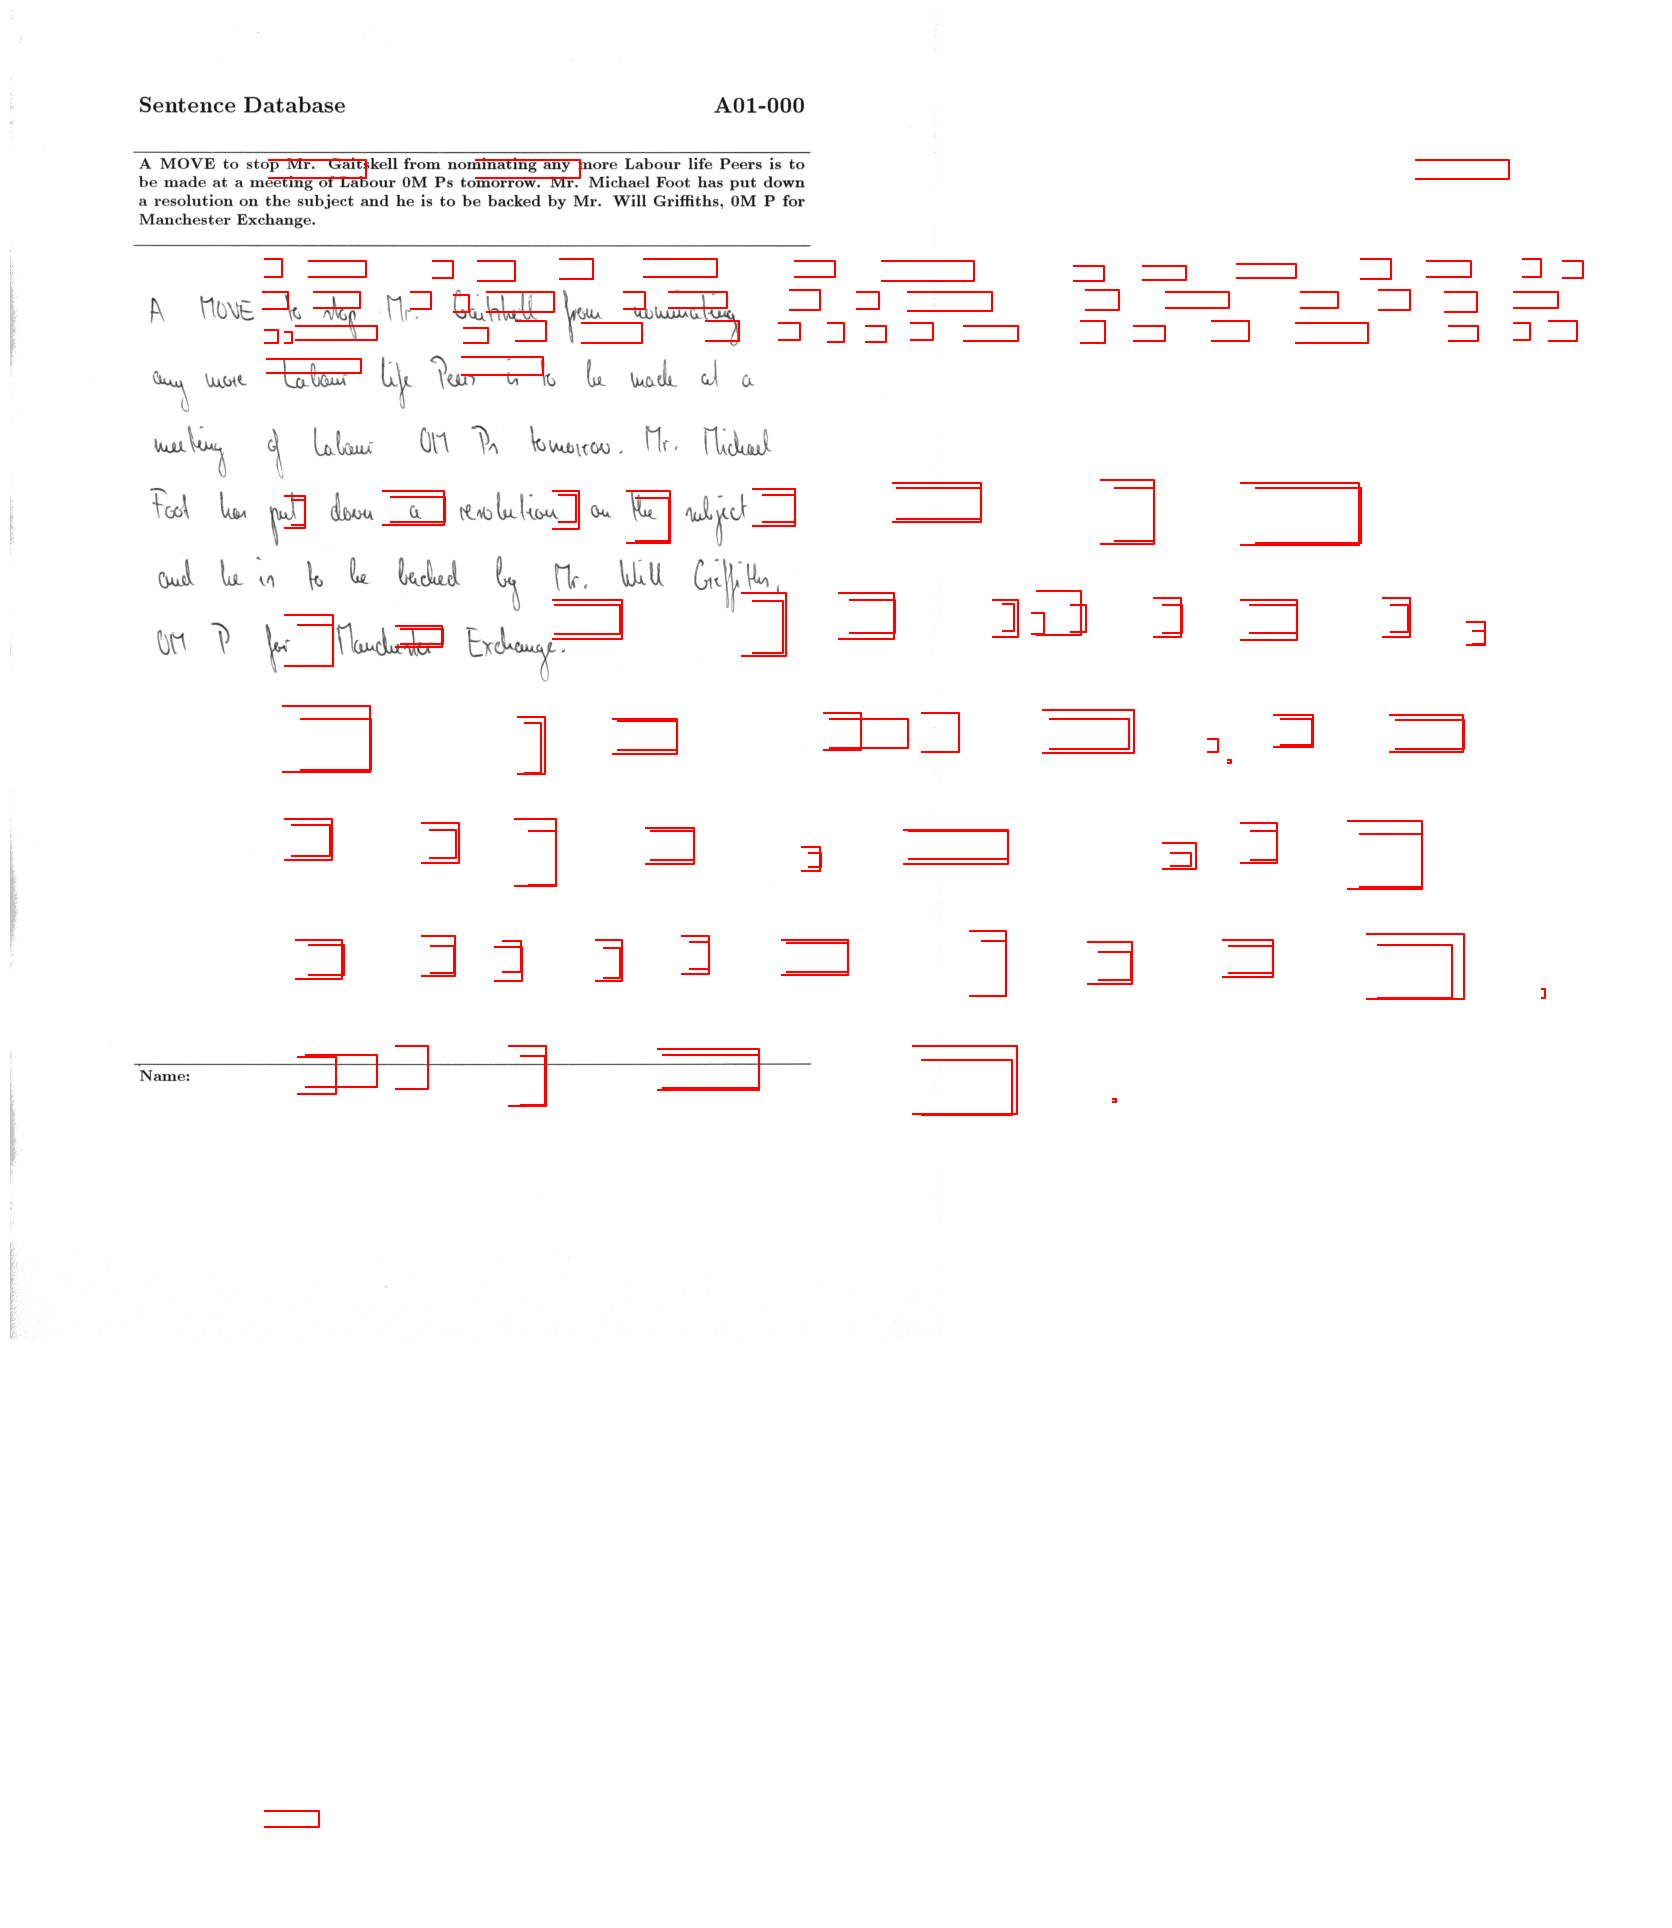

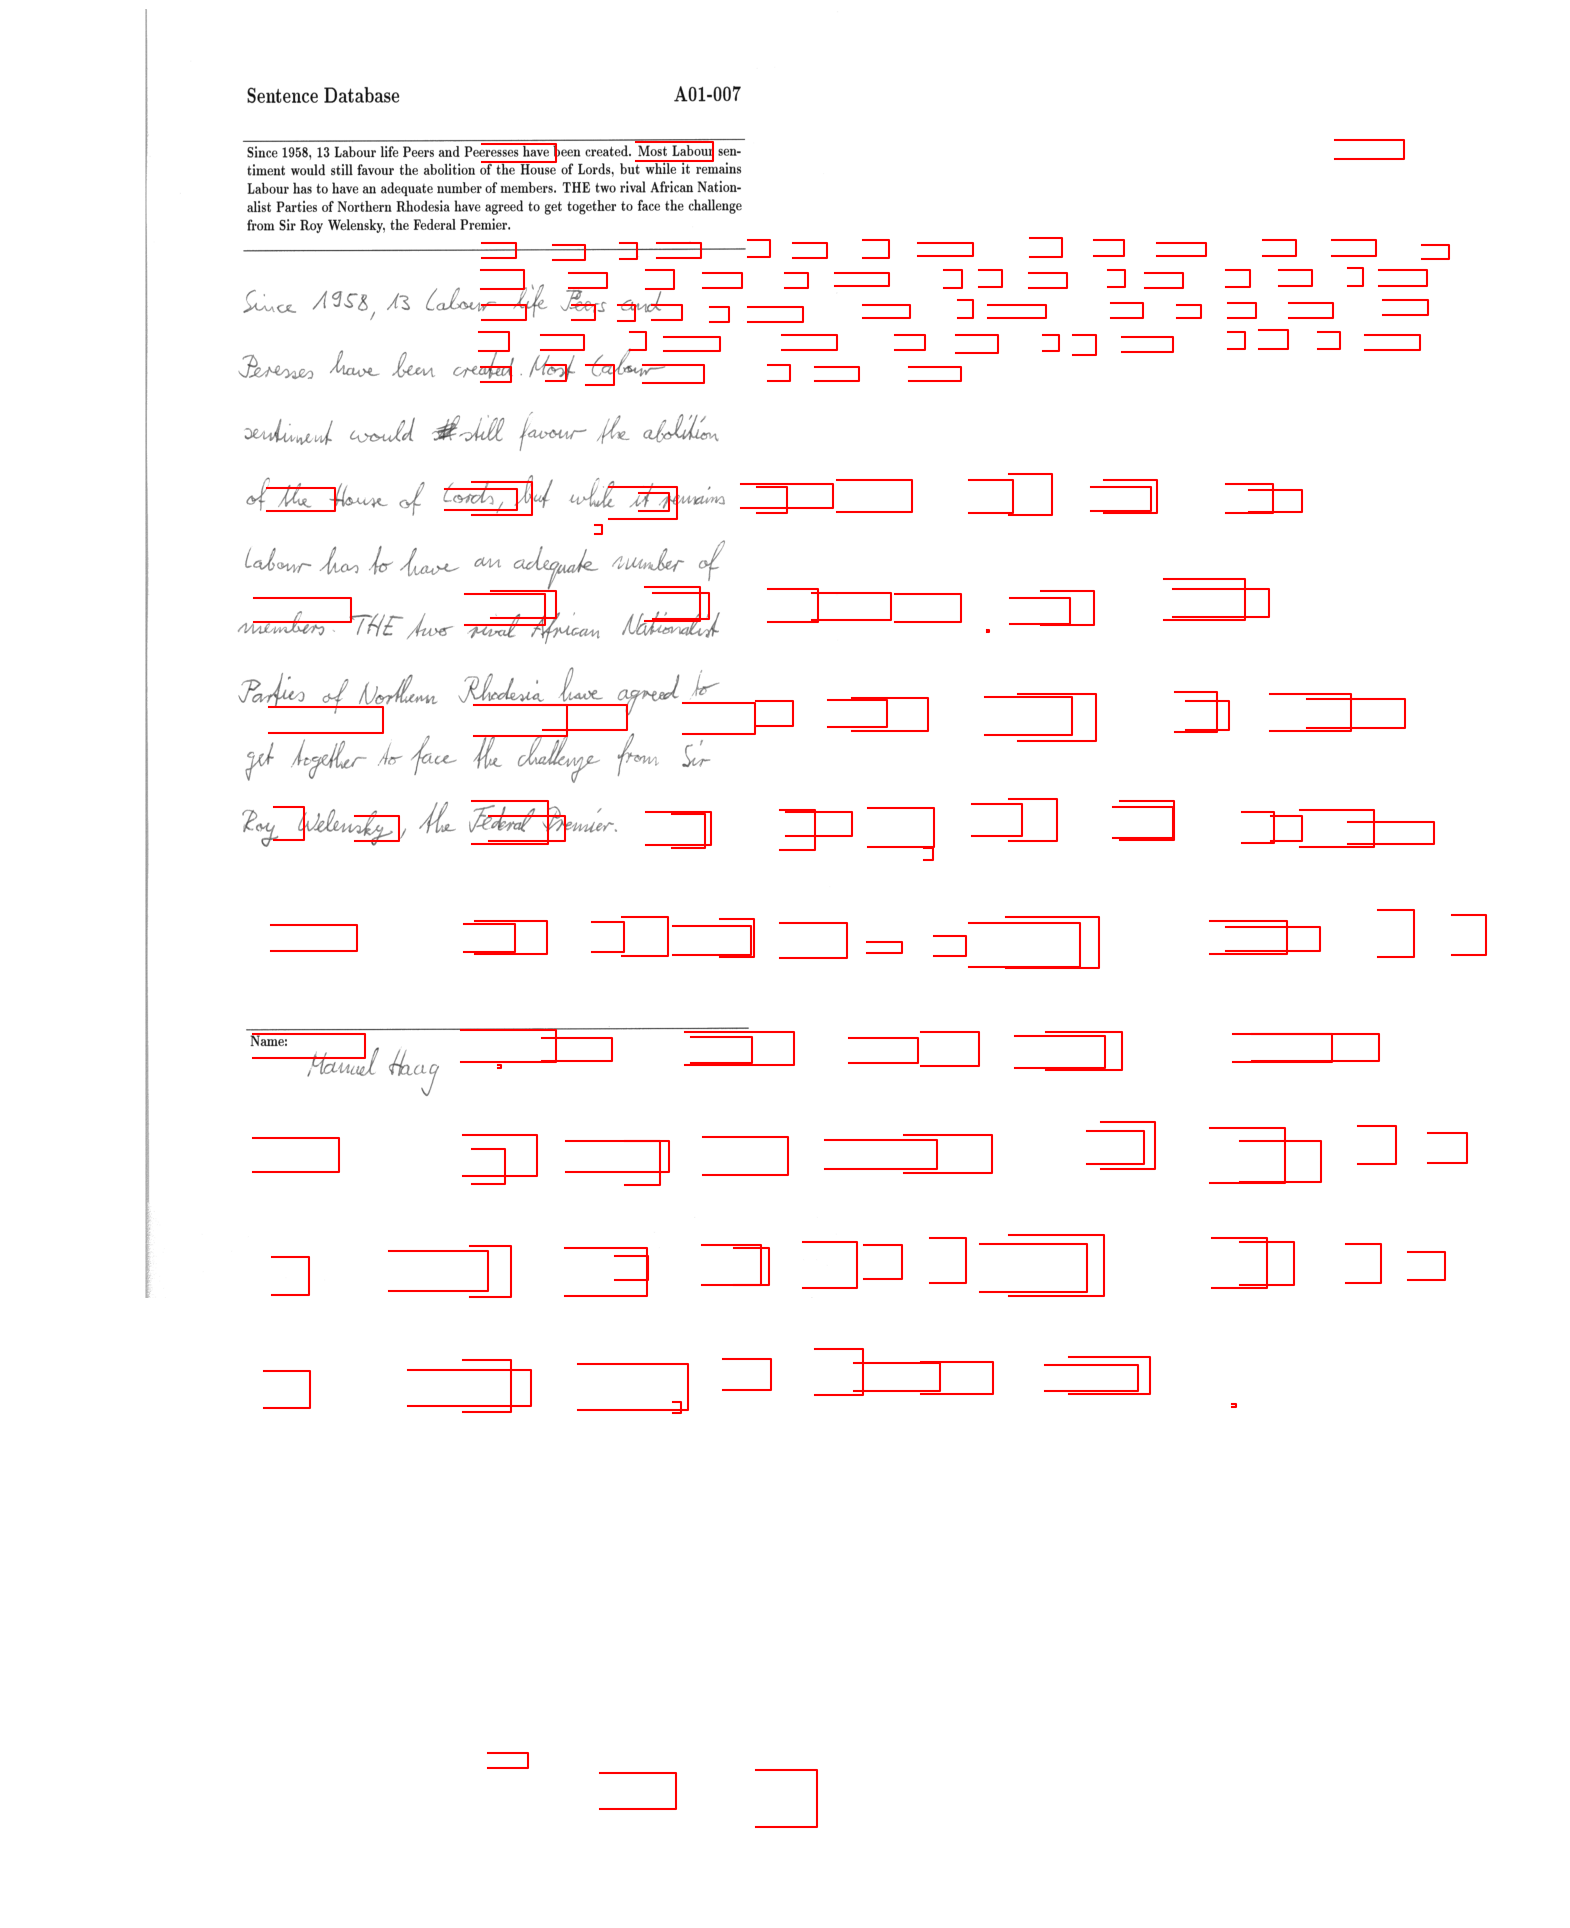

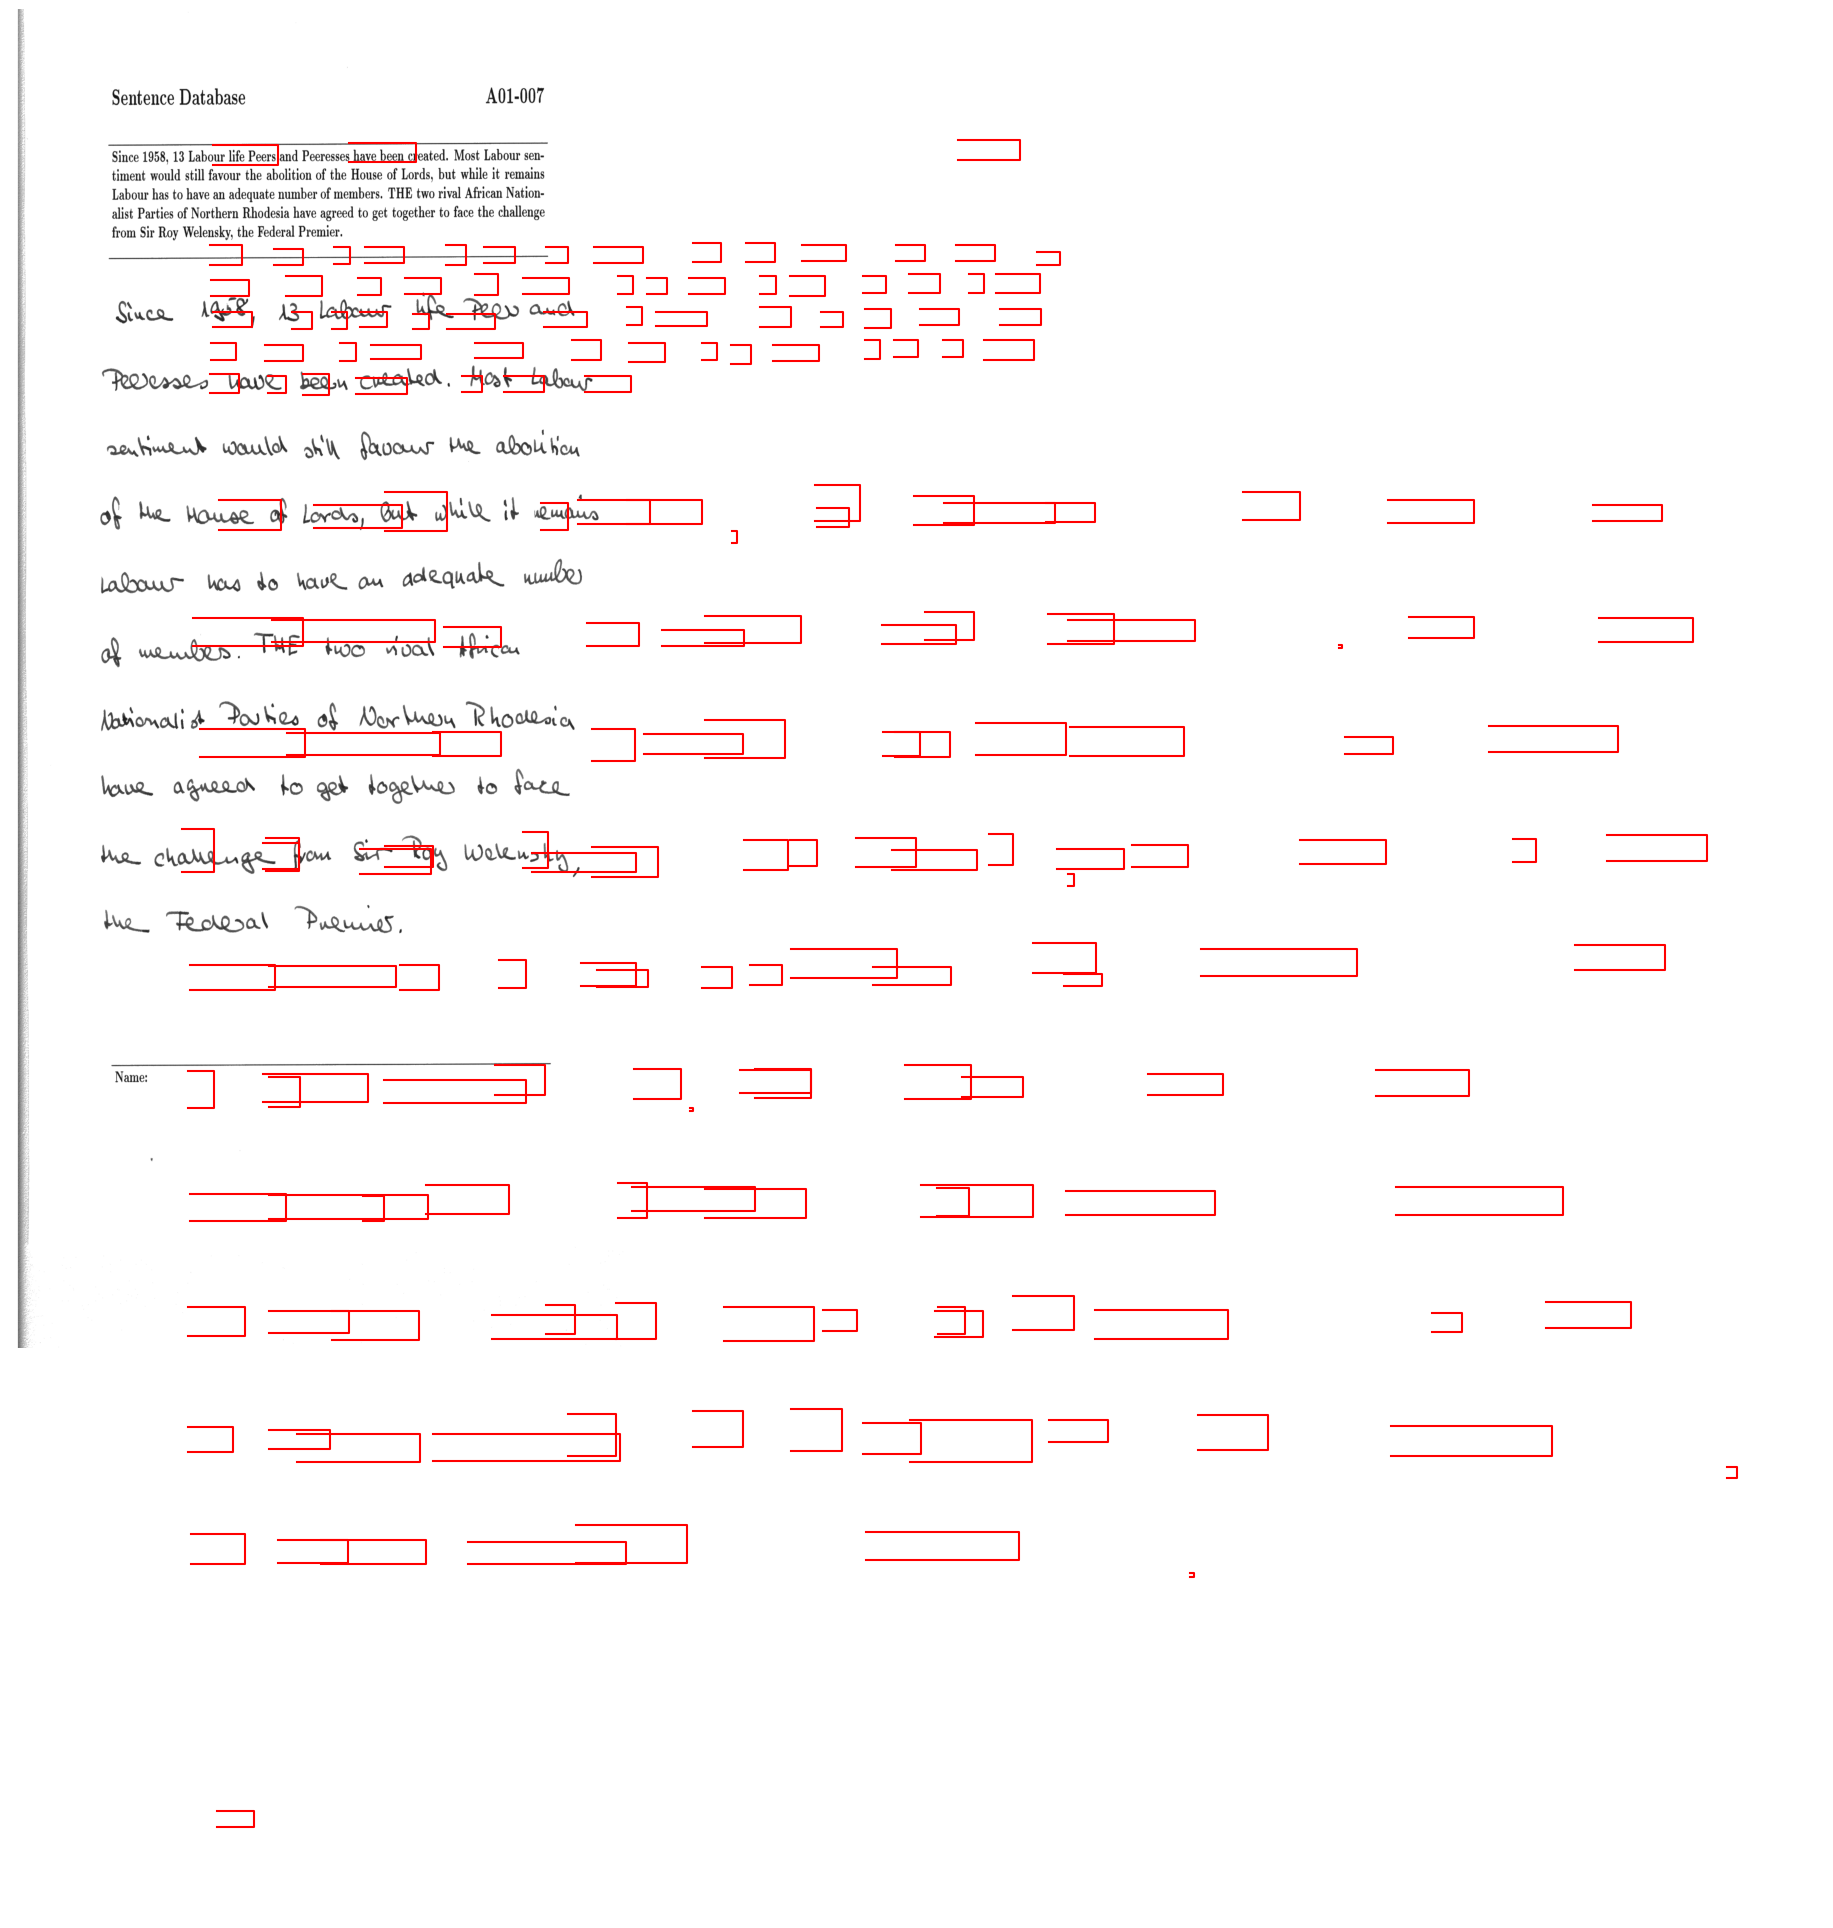

In [44]:
import numpy as np

def plot_img_with_polygons(key, data):
    filepath = "text_detection_train/images/" + key

    fig, ax = plt.subplots()
    fig.set_figheight(FORM_IMG_SIZE[0] / 100)
    fig.set_figwidth(FORM_IMG_SIZE[1] / 100)
    fig.set_dpi(100)
    plt.axis('off')
    ax.imshow(plt.imread(filepath), cmap='gray')
    for polygon_data in data['polygons']:
        x = np.array(polygon_data)[:,0] + polygon_data[0][0] 
        y = np.array(polygon_data)[:,1] + polygon_data[0][1]
        ax.plot(x, y, color='red')
    plt.show()

i = 0
stop = 2
for key in train_json:
    i += 1
    plot_img_with_polygons(key, train_json[key])
    if i > stop:
        break

# Training

In [34]:
import os
os.system('python doctr/references/detection/train_tensorflow.py --help')

usage: train_tensorflow.py [-h] [--name NAME] [--epochs EPOCHS]
                           [-b BATCH_SIZE] [--input_size INPUT_SIZE] [--lr LR]
                           [-j WORKERS] [--resume RESUME] [--test-only]
                           [--freeze-backbone] [--show-samples] [--wb]
                           [--push-to-hub] [--pretrained] [--rotation]
                           [--eval-straight] [--amp] [--find-lr]
                           train_path val_path arch

DocTR training script for text detection (TensorFlow)

positional arguments:
  train_path            path to training data folder
  val_path              path to validation data folder
  arch                  text-detection model to train

optional arguments:
  -h, --help            show this help message and exit
  --name NAME           Name of your training experiment (default: None)
  --epochs EPOCHS       number of epochs to train the model on (default: 10)
  -b BATCH_SIZE, --batch_size BATCH_SIZE
                  

0

Run the following command to train Doctr

```bash
python doctr/references/detection/train_tensorflow.py text_detection_train text_detection_val db_resnet50 --pretrained --freeze-backbone --name fine_tuning
```

`--rotation`

https://developer.apple.com/forums/thread/693678

```bash
pip uninstall tensorflow-metal
```

# Evaluating

## Without training 

In [103]:
from doctr.models import ocr_predictor

test_form_id = df.iloc[0].form_id
form_img_path = get_preprocessed_form_img_path_from_id(test_form_id)

def get_original_doctr_prediction(filepath):
    original_model = ocr_predictor(
        det_arch = 'db_resnet50',    
        reco_arch = 'crnn_vgg16_bn', 
        pretrained = True
    )
    doc = DocumentFile.from_images(form_img_path)
    det_res = original_model.det_predictor(doc)
    return scale_doctr_coords(det_res[0])

doctr_test_coords = get_original_doctr_prediction(form_img_path)


In [104]:
doctr_test_coords

[[[0.13671875, 0.7958984375],
  [0.1943359375, 0.7958984375],
  [0.1943359375, 0.8076171875],
  [0.13671875, 0.8076171875]],
 [[0.484375, 0.4580078125],
  [0.595703125, 0.4580078125],
  [0.595703125, 0.5087890625],
  [0.484375, 0.5087890625]],
 [[0.154296875, 0.462890625],
  [0.1953125, 0.462890625],
  [0.1953125, 0.490234375],
  [0.154296875, 0.490234375]],
 [[0.34765625, 0.458984375],
  [0.4560546875, 0.458984375],
  [0.4560546875, 0.490234375],
  [0.34765625, 0.490234375]],
 [[0.267578125, 0.4580078125],
  [0.306640625, 0.4580078125],
  [0.306640625, 0.5029296875],
  [0.267578125, 0.5029296875]],
 [[0.20703125, 0.4580078125],
  [0.2412109375, 0.4580078125],
  [0.2412109375, 0.490234375],
  [0.20703125, 0.490234375]],
 [[0.7275390625, 0.408203125],
  [0.83203125, 0.408203125],
  [0.83203125, 0.45703125],
  [0.7275390625, 0.45703125]],
 [[0.578125, 0.412109375],
  [0.625, 0.412109375],
  [0.625, 0.443359375],
  [0.578125, 0.443359375]],
 [[0.259765625, 0.4140625],
  [0.2890625, 0.4140

(0.0, 3542.0)
(2479.0, 0.0)


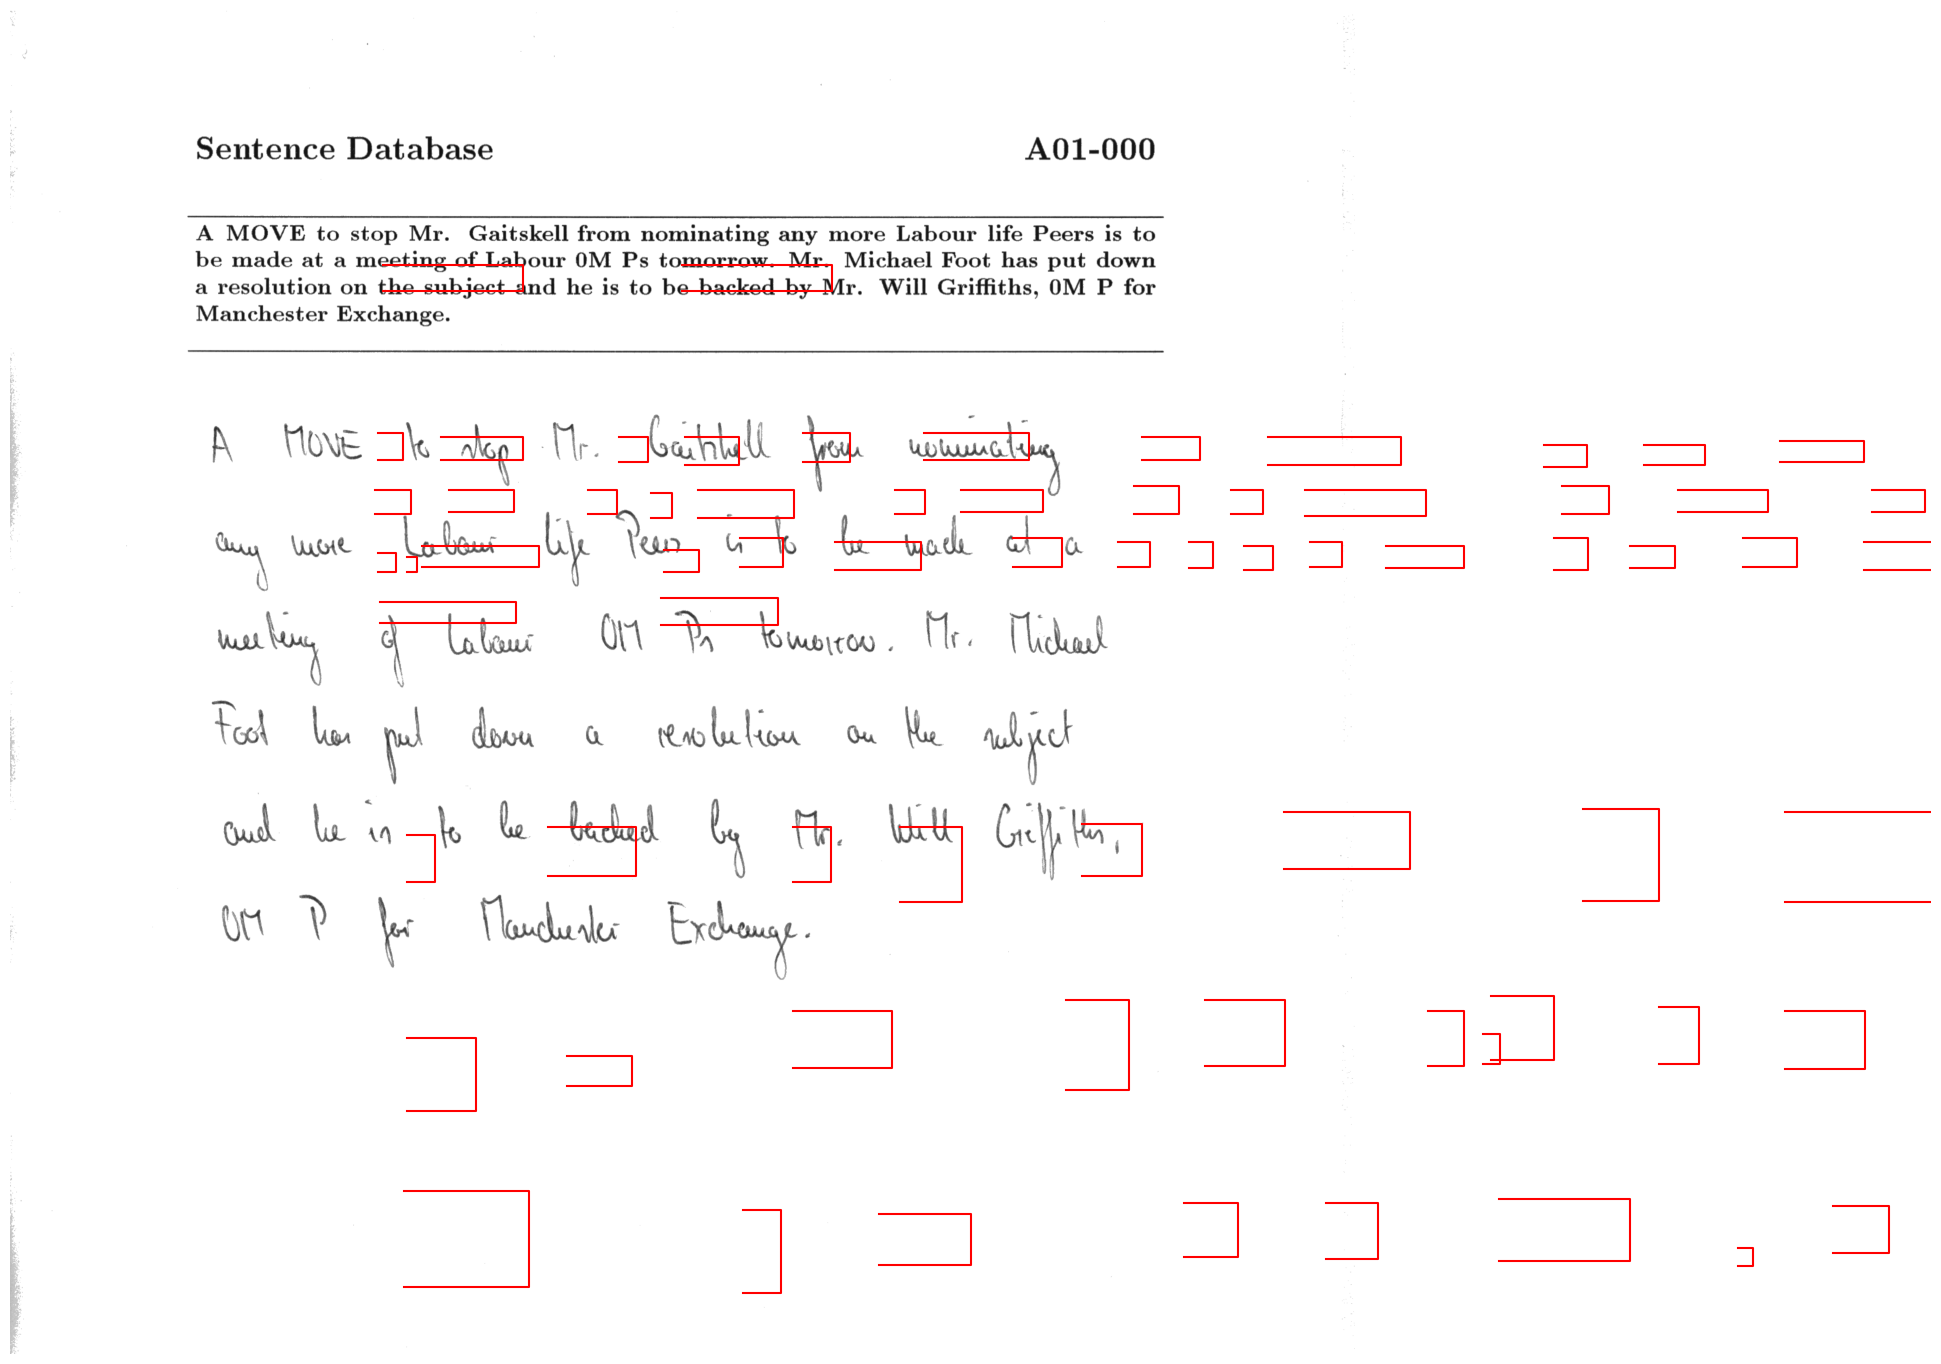

In [109]:
def show_bboxes(form_img_path, coords):
    fig, ax = plt.subplots()
    ax.set_facecolor('xkcd:salmon')

    fig.set_figwidth(FORM_IMG_SIZE[0] / 100)
    fig.set_figheight(FORM_IMG_SIZE[1] / 100)
    fig.set_dpi(100)
    plt.axis('off')
    ax.imshow(plt.imread(form_img_path), cmap='gray')
    ax.set_xlim(0, FORM_IMG_SIZE[1])
    ax.set_ylim(FORM_IMG_SIZE[0], 0)
    print(ax.get_xlim())
    print(ax.get_ylim())
    for polygon_data in coords:
        x = np.array(polygon_data)[:,0] + polygon_data[0][0] 
        y = np.array(polygon_data)[:,1] + polygon_data[0][1]
        ax.plot(x * FORM_IMG_SIZE[0], y * FORM_IMG_SIZE[1], color='red')
    plt.show()

show_bboxes(form_img_path, doctr_test_coords)

In [ ]:
plt.figure()

## With training